# Clifford Explorer

Interactive Clifford Attractor Viewer

Author: Joseph Barraud (November 2023)

An [attractor](https://en.wikipedia.org/wiki/Attractor) is a set of values to which a numerical system tends to evolve. An attractor is called a [strange attractor](https://en.wikipedia.org/wiki/Attractor#Strange_attractor) if the resulting pattern has a fractal structure. 

This notebook has been inspired by the [PyViz attractors notebook](https://examples.holoviz.org/attractors/attractors.html) that was originally developed to show how to calculate and plot two-dimensional attractors of a variety of types. The notebook, as well as a couple of companion notebooks, makes heavy use of [numba](https://numba.pydata.org/) and [Datashader](https://datashader.org) to speed up calculations and rendering. The user can explore various types of attractors and their parameters in an interactive application powered by [panel](https://panel.holoviz.org/).

In this new version, the code has been updated to take advantage of recent improvements in panel (version > 1.0). It also adds multiprocessing to the calculation of the attractor's trajectory.

References in the original notebook:
- [Lazaro Alonso](https://nextjournal.com/lazarus/aggregating-values-to-the-mandelbrot-and-julia-sets)
- [François Pacull](https://aetperf.github.io/2018/08/29/Plotting-Hopalong-attractor-with-Datashader-and-Numba.html)
- [Jason Rampe](https://softologyblog.wordpress.com/2017/03/04/2d-strange-attractors)
- [Paul Bourke](http://paulbourke.net/fractals/)
- [James A. Bednar](http://github.io/jbednar).


## Imports

In [1]:
from collections.abc import Callable
from math import cos, sin
from multiprocessing import Pool

import datashader as ds
import numpy as np
import pandas as pd
import panel as pn
from datashader import transfer_functions as tf
from numba import jit

In [2]:
# Globals
RND_GEN = np.random.default_rng()
RESOLUTIONS = {'Low': 100_000, 'Medium': 1_000_000, 'High': 10_000_000}

In [3]:
pn.extension(template='bootstrap')

## Clifford Attractors

A [Clifford Attractor](http://paulbourke.net/fractals/clifford) is a strange attractor defined by two iterative equations that determine the _x,y_ locations of discrete steps in the path of a particle across a 2D space, given a starting point _(x0,y0)_ and the values of four parameters _(a,b,c,d)_:

\begin{equation}
x_{n +1} = \sin(a y_{n}) + c \cos(a x_{n})\\
y_{n +1} = \sin(b x_{n}) + d \cos(b y_{n})
\end{equation}

At each time step, the equations define the location for the following time step, and the accumulated locations show the areas of the 2D plane most commonly visited by the imaginary particle.  First, we define the iterative attractor equation:


In [4]:
@jit(nopython=True)
def clifford(x, y, a, b, c, d, *o) -> tuple[float, float]:
    """Calculate location of next step using the Clifford attractor equation."""
    return sin(a * y) + c * cos(a * x), sin(b * x) + d * cos(b * y)

We then evaluate this equation 10 million times, creating a set of _x,y_ coordinates visited. The `@jit` here and above is optional, but it makes the code 50x faster.

## Using multiprocessing to calculate the trajectory

Since the rendering of the attractor aggregates points in pixels, it does not actually matter what the starting point of the trajectory is. This means that multiple trajectories can be calculated from multiple starting points ("origins"). We can therefore compute several trajectories in parallel and accumulate more points in less time.

Additional details:

- Points are accumulated in the trajectory only if they belong to a specific area in the 2D space ("calculation window")
- The origins are initialised randomly within the calculation window

In [5]:
@jit(nopython=True)
def selected_clifford(x: float, y: float) -> tuple[float, float]:
    """Calculate location of next step using the Clifford attractor equation for a particular set of parameters."""
    return clifford(x, y, a=-1.3, b=-1.3, c=-1.8, d=-1.9)


@jit(nopython=True)
def calculate_trajectory(
    func: Callable[[float, float], tuple[float, float]],
    origin: tuple[float, float] = (0, 0),
    xlim: tuple[float, float] = (-2, 2),
    ylim: tuple[float, float] = (-2, 2),
    n_points: int = 1000000,
) -> tuple[list[float], list[float]]:
    """Calculate trajectory of an attractor and limit the output to given 2D boundaries."""
    x_coords: list[float] = []
    y_coords: list[float] = []

    xn, yn = origin
    for _ in range(n_points):
        x_next, y_next = func(xn, yn)
        if (x_next >= xlim[0]) and (x_next <= xlim[1]) and (y_next >= ylim[0]) and (y_next <= ylim[1]):
            x_coords.append(x_next)
            y_coords.append(y_next)
        xn, yn = x_next, y_next
    return x_coords, y_coords


def trajectory_dataframe(
    func: Callable[[float, float], tuple[float, float]],
    origin: tuple[float, float] = (0, 0),
    xlim: tuple[float, float] = (-2, 2),
    ylim: tuple[float, float] = (-2, 2),
    n_points: int = 1000000,
) -> pd.DataFrame:
    """Calculate trajectory of an attractor and limit the output to given 2D boundaries."""
    x, y = calculate_trajectory(func, origin, xlim, ylim, n_points)
    return pd.DataFrame({'x': x, 'y': y})


def render_attractor(trajectory: pd.DataFrame, plot_width: int = 600, plot_height: int = 600):
    """Render attractor's trajectory into an image using datashader."""
    cvs = ds.Canvas(plot_width, plot_height)
    agg = cvs.points(trajectory, 'x', 'y')
    yield tf.shade(agg, cmap=['white', 'black'])


def generate_image(
    xlim: tuple[float, float], ylim: tuple[float, float], n_points: int, n_origins: int = 24, nprocs: int = 8
):
    """Create image of the attractor's trajectory limited to a given region."""
    xmin, xmax = xlim
    ymin, ymax = ylim
    origins = RND_GEN.uniform((xmin, ymin), (xmax, ymax), size=(n_origins, 2))
    args = [(selected_clifford, origin, xlim, ylim, n_points) for origin in origins]

    with Pool(nprocs) as p:
        all_dfs = p.starmap(trajectory_dataframe, args)
    return render_attractor(pd.concat(all_dfs))

## Interactive Attractor Explorer

You can run this notebook through Bokeh Server using:

```
panel serve --show clifford_explorer.ipynb
```

In [12]:
class Explorer:
    """Panel app."""

    x_slider = pn.widgets.RangeSlider(
        name='X boundaries', start=-3, end=3, value=(-3, 3), step=0.1, bar_color='lightblue'
    )
    y_slider = pn.widgets.RangeSlider(
        name='Y boundaries', start=-3, end=3, value=(-3, 3), step=0.1, disabled=True, bar_color='blue'
    )
    x_resetbutton = pn.widgets.Button(name='Reset', button_type='primary')
    y_resetbutton = pn.widgets.Button(name='Reset', button_type='primary')
    switch = pn.widgets.Switch(name='Link X and Y Sliders', value=True)
    switch_label = pn.pane.Markdown('### Link X and Y Sliders')
    n_points = pn.widgets.IntSlider(
        start=100_000,
        end=10_000_000,
        step=10_000,
        value=100_000,
        name='Number of points',
        format=',',
        sizing_mode='stretch_width',
    )
    resolution = pn.widgets.RadioButtonGroup(
        name='Resolution (n points)',
        options=['Low', 'Medium', 'High'],
        value='Low',
        button_type='success',
        sizing_mode='stretch_width',
    )

    def __init__(self):
        self.x_resetbutton.link(self.x_slider, callbacks={'value': self.reset_slider})
        self.y_resetbutton.link(self.y_slider, callbacks={'value': self.reset_slider})
        self.watcher1 = self.resolution.param.watch(self.set_npoints, 'value')
        self.watcher2 = self.switch.param.watch_values(self.freeze_slider, 'value')
        self.watcher3 = self.x_slider.param.watch_values(self.copy_slider, 'value')
        self.image = pn.bind(generate_image, xlim=self.x_slider, ylim=self.y_slider, n_points=self.n_points)

    def copy_slider(self, **params):
        if self.switch.value:
            self.y_slider.value = params['value']

    def freeze_slider(self, **params):
        if params['value']:
            self.y_slider.value = self.x_slider.value
            self.y_slider.disabled = True
        else:
            self.y_slider.disabled = False

    def reset_slider(self, target, event):
        target.value = (-3, 3)

    def set_npoints(self, *events):
        for event in events:
            if event.name == 'value' and self.resolution.value is not None:
                self.n_points.value = RESOLUTIONS[self.resolution.value]

    def view(self):
        return pn.Column(
            pn.Row(self.x_slider, self.x_resetbutton, pn.WidgetBox('### Link X and Y Sliders', self.switch)),
            pn.Row(self.y_slider, self.y_resetbutton),
            pn.WidgetBox('### Resolution', self.resolution, self.n_points, width=300),
            self.image,
        )

Column
    [0] Row
        [0] RangeSlider(bar_color='lightblue', end=3, name='X boundaries', start=-3, value=(-3, -0.2999999999999998), value_end=-0.2999999999999998, value_start=-3)
        [1] Button(button_type='primary', name='Reset')
        [2] Column
            [0] Markdown(str)
            [1] Switch(name='Link X and Y Sliders', value=True)
    [1] Row
        [0] RangeSlider(bar_color='blue', disabled=True, end=3, name='Y boundaries', start=-3, value=(-3, -0.2999999999999998), value_end=-0.2999999999999998, value_start=-3)
        [1] Button(button_type='primary', name='Reset')
    [2] RadioButtonGroup(button_type='success', name='Resolution (n points)', options=['Low', 'Medium', 'High'], value='Medium')
    [3] IntSlider(end=10000000, format=',', name='Number of points', start=100000, step=10000, value=1000000)
    [4] ParamFunction(function, _pane=PNG, defer_load=False)
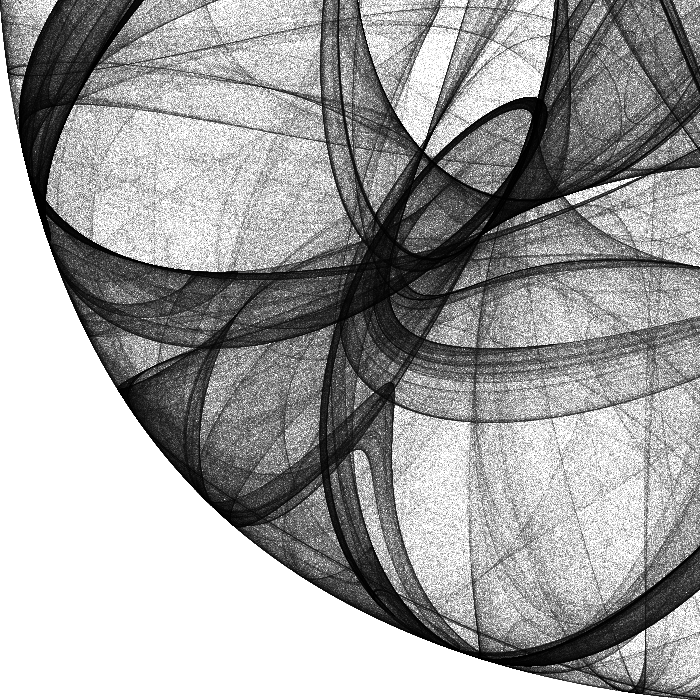

In [9]:
pn.config.throttled = True
explorer = Explorer()
explorer.view().servable(title='Clifford Explorer')